In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan 
from scipy.stats import norm
import seaborn as sns
from collections import OrderedDict

from stan.helpers import StanModel_cache

%matplotlib inline

In [2]:
def model(file: str) -> "StanModel":
    if file.split('/')[1][:2] == 'os':
        with open(file) as f:
            code = f.read()
        with open("stan/functions.stan") as f:
            functions = f.read()
        stan_code = functions + code
    else:
        with open(file) as f:
            stan_code = f.read()
    return StanModel_cache(model_code=stan_code)


model_dict = OrderedDict()
model_dict['os'] = model("stan/os_normal.stan")
model_dict['cdf_fit'] =  model("stan/cdf_fit.stan")

Using cached StanModel
Using cached StanModel


In [3]:
def get_data(N, M, q_min, q_max, f, equidistant_q=False):
    """if quidistant_q is False. The steps in x are equidistant
        f need an rvs() method - scipy stats function"""
    if equidistant_q:
        q = np.linspace(q_min, q_max, M)
        samples = f.rvs(size=N)
        X = np.percentile(samples, 100*q)
    else:
        X_min, X_max = f.ppf([q_min, q_max])
        X = np.linspace(X_min, X_max, M)
        q = f.cdf(X)
    return q, X


mu, sigma = 3, 1.5
N = 200
M =  10
q_min, q_max = 0.05, 0.95
#q = np.linspace(0.1, 0.9, 20)
f = norm(loc=mu, scale=sigma)

q, X = get_data(N, M, q_min, q_max, f, equidistant_q=True)

print(*zip(q, X), sep="\n")

(0.05, 0.6559486000350092)
(0.15, 1.35764589426071)
(0.25, 1.8783023249179096)
(0.35, 2.3895704872485197)
(0.44999999999999996, 2.8016229190076283)
(0.5499999999999999, 3.1689300974569288)
(0.65, 3.528835250302472)
(0.75, 4.060179180658741)
(0.85, 4.698293934319439)
(0.95, 5.254645070732461)


In [4]:
data_dict = {"N":N, "M":M, "q":q, "X":X}

sample_dict = dict()
for model_name, model in model_dict.items():
    sample_dict[model_name] = model.sampling(data_dict)

/home/nirwan/.local/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


N=200, M=10
True paramters: mu=3, sigma=1.5


/home/nirwan/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


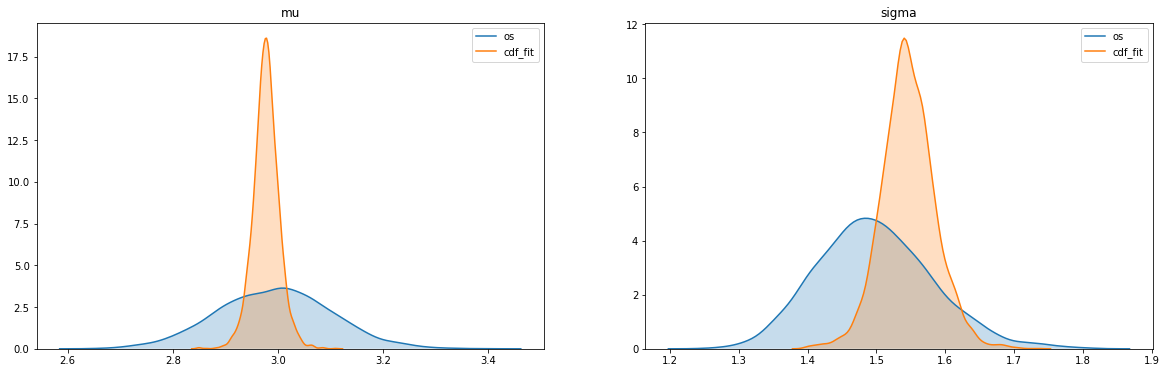

In [5]:
def plot(params, models, sample_dict, figsize=(20,6)):
    fig, axes = plt.subplots(1, len(params), figsize=figsize)
    for i, (param, ax) in enumerate(zip(params, axes)):
        ax = plot_ax(param, models, sample_dict, ax)
    return fig


def plot_ax(param, models, sample_dict, ax):
    for model in models:
        samples_param = sample_dict[model][param]
        sns.kdeplot(samples_param, shade=True, ax=ax, label=model)
    ax.set_title(param)
    return ax


show_models = ["os", "cdf_fit"]
show_params = ["mu", "sigma"]

print("N={}, M={}".format(N, M))
print("True paramters: mu={}, sigma={}".format(mu, sigma))
plot(show_params, show_models, sample_dict);

## Dependency in N

In [6]:
mu, sigma = 3, 1.5
M =  10
q_min, q_max = 0.05, 0.95

q = np.linspace(q_min, q_max, M)
f = norm(loc=mu, scale=sigma)
X = f.ppf(q)

print(*zip(q, X), sep="\n")

(0.05, 0.5327195595727909)
(0.15, 1.4453499157593153)
(0.25, 1.9882653747058774)
(0.35, 2.4220193003886483)
(0.44999999999999996, 2.8115079797173887)
(0.5499999999999999, 3.188492020282611)
(0.65, 3.5779806996113517)
(0.75, 4.011734625294123)
(0.85, 4.554650084240684)
(0.95, 5.467280440427208)


In [7]:
model_name = "os"
model = model_dict[model_name]

sample_dict = OrderedDict()
Ns = [20, 50, 100, 200, 500]
for N in Ns:
    data_dict = {"N":N, "M":M, "q":q, "X":X}

    sample_dict[N] = model.sampling(data_dict)

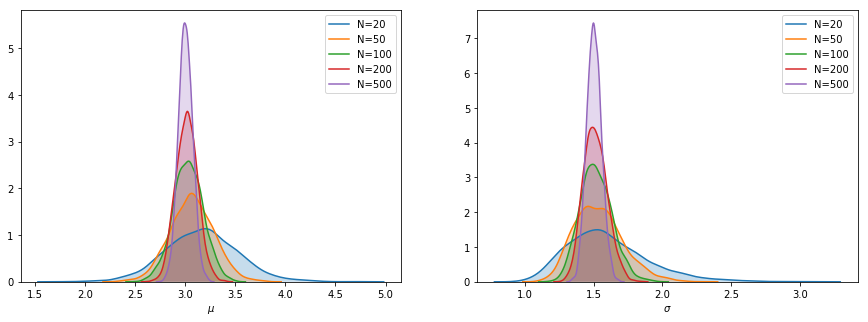

In [8]:
def plot_density(arrays: "[,N]", ax, labels=None):
    if len(arrays.shape) == 1:
        sns.kdeplot(arrays, shade=True, ax=ax, label=labels)
    else:
        for i, array in enumerate(arrays):
            sns.kdeplot(arrays[i], shade=False, ax=ax, label=labels[i])
    return ax


fig, axes = plt.subplots(1, 2, figsize=(15,5))

for N, stan_samples in sample_dict.items():
    ax = axes[0]
    ax = plot_density(stan_samples.extract('mu')['mu'], ax, "N={}".format(N))

    ax = axes[1]
    ax = plot_density(stan_samples.extract('sigma')['sigma'], ax, "N={}".format(N))

axes[0].set_xlabel("$\mu$")
axes[1].set_xlabel("$\sigma$");

## Change in the posterior parameter distribution as a function of X[0]
for each value of X[0] in some range save quantiles of posterior dist

In [9]:
%%time
mu, sigma = 3, 1.5
N = 200
#q = np.array([0.1, 0.5])
q = np.linspace(0.01, 0.99, 20)

M = q.shape[0]
samples = np.random.normal(mu, sigma, N)

D = 50
xs = np.linspace(mu-7*sigma, mu+7*sigma, D)

mus = dict((model_name, np.zeros((D,4000))) 
            for model_name in model_dict.keys())
sigmas = dict((model_name, np.zeros((D,4000))) 
                for model_name in model_dict.keys())
for d, x in enumerate(xs):
    samples[0] = x
    X = np.percentile(samples, 100*q)
    
    data_dict = {"N":N, "M":M, "q":q, "X":X}

    for model_name, model in model_dict.items():
        stan_samples = model.sampling(data_dict)
        mus[model_name][d,:] = stan_samples.extract("mu")["mu"]
        sigmas[model_name][d,:] = stan_samples.extract("sigma")["sigma"]

CPU times: user 1.44 s, sys: 3.1 s, total: 4.54 s
Wall time: 27.7 s


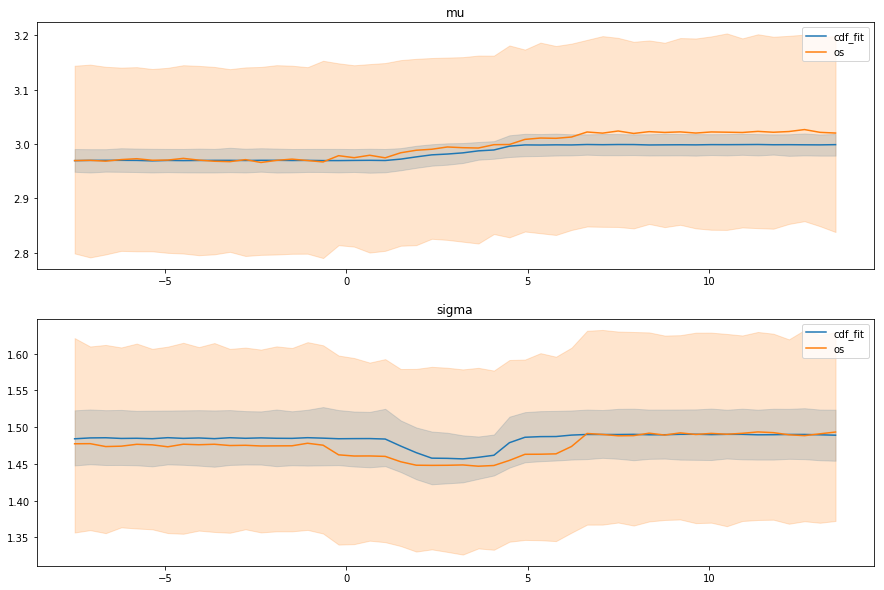

In [10]:
def plot_2(f, sample_dict, xs, ax, title=None):
    """sample_dict = model_name: np.array(D, n_samples)"""
    c = sns.color_palette()
    for i, (model_name, samples) in enumerate(sample_dict.items()):
        f(model_name, samples, xs, ax, c=c[i])
    ax.legend()
    if title: ax.set_title(title)
        
        
def quantile_plot(model_name, samples, xs, ax, **kwargs):
    low, mid, high = np.percentile(samples, [5, 50, 95], axis=1)
    ax.plot(xs, mid, label=model_name, color=kwargs["c"])
    ax.fill_between(xs, high, low, alpha=0.2, color=kwargs["c"])

    

fig, axes = plt.subplots(2, 1, figsize=(15,10))
plot_2(quantile_plot, mus, xs, axes[0], title="mu")
plot_2(quantile_plot, sigmas, xs, axes[1], title="sigma")

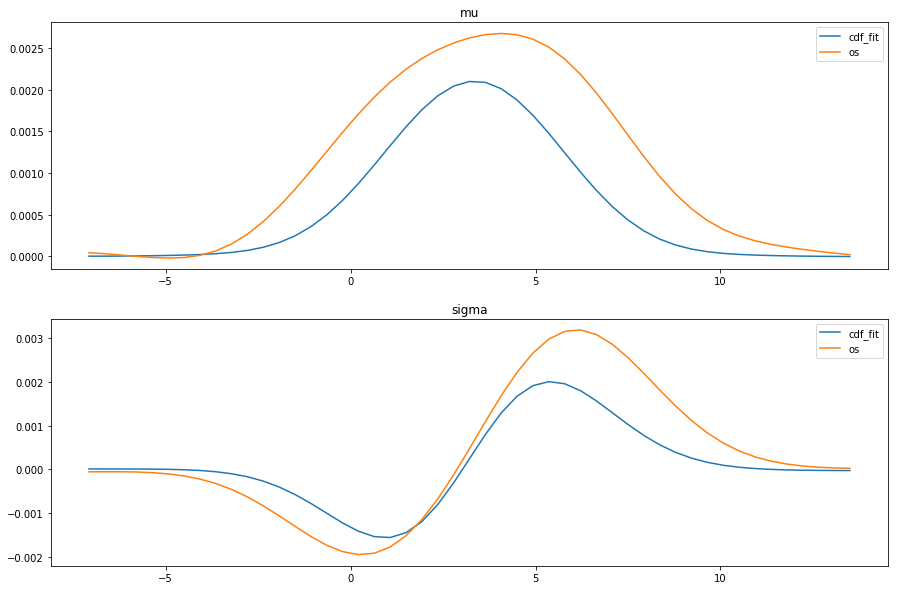

In [11]:
def kernel_smoother(kernel, x, y):
    kweights_i = lambda x_i: kernel(x_i, x)
    y_i = lambda kw_i: sum(np.multiply(kw_i, y))/sum(kw_i)
    return [y_i(kweights_i(x_i)) for x_i in x]


def rbf_kernel(x1, x2, l):
    return np.exp(-0.5* np.square((x1-x2)/l))


kernel = lambda x1, x2: rbf_kernel(x1, x2, 2.)


def diff_plot(model_name, samples, xs, ax, **kwargs):
    median = np.percentile(samples, 50, axis=1)
    median_smoothed = kernel_smoother(kernel, xs, median)
    median_diff = np.diff(median_smoothed)
    ax.plot(xs[1:], median_diff, label=model_name)


fig, axes = plt.subplots(2, 1, figsize=(15,10))
plot_2(diff_plot, mus, xs, axes[0], title="mu")
plot_2(diff_plot, sigmas, xs, axes[1], title="sigma")

change in mean for cdf_fit: 0.02914685156624186
change in mean for os: 0.04994331593808887


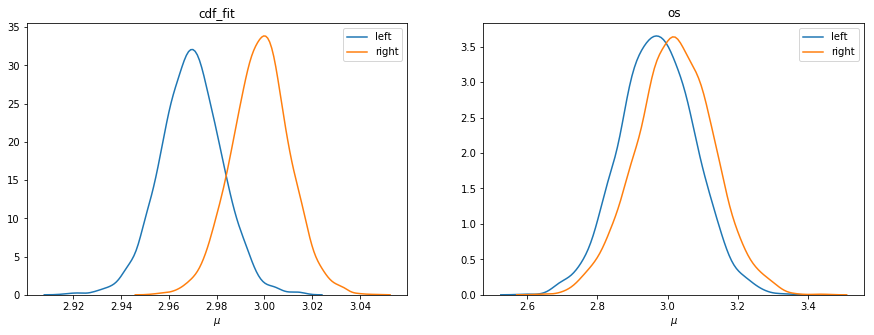

In [12]:
fig, axes = plt.subplots(1, len(mus), figsize=(15,5))
for i, (model, samples_model) in enumerate(mus.items()):
    left = samples_model[0, :]
    right = samples_model[-1, :]
    print('change in mean for {}: {}'.format(model, right.mean()-left.mean()))
    sns.kdeplot(left, ax=axes[i], label='left')
    sns.kdeplot(right, ax=axes[i], label='right')
    axes[i].set_title(model)
    axes[i].set_xlabel('$\mu$')

## misspecified model
samples from student t  
fit with gaussian

In [13]:
from scipy.stats import t

loc, scale = 3, 1.5
df = 2
N = 900
#q = np.array([0.1, 0.5])
q = np.linspace(0.1, 0.9, 20)

M = q.shape[0]
samples = t.rvs(df, loc, scale, size=N)
X = np.percentile(samples, 100*q)

print(*zip(q, X), sep="\n")

(0.1, 0.16567862426244717)
(0.14210526315789473, 0.7937527494372973)
(0.1842105263157895, 1.3042183803312668)
(0.22631578947368422, 1.6012702511389483)
(0.26842105263157895, 1.8869063666395869)
(0.31052631578947365, 2.059073667979277)
(0.3526315789473684, 2.208534774250571)
(0.39473684210526316, 2.3900809369950116)
(0.4368421052631579, 2.629940769033113)
(0.4789473684210527, 2.845342036157205)
(0.5210526315789473, 3.004520809876384)
(0.5631578947368421, 3.1771784251572335)
(0.6052631578947368, 3.3253149453628708)
(0.6473684210526316, 3.5005161699012635)
(0.6894736842105262, 3.7250927023002047)
(0.731578947368421, 3.9510002283127763)
(0.7736842105263158, 4.261125243170458)
(0.8157894736842105, 4.545029772963597)
(0.8578947368421053, 4.905784209222093)
(0.9, 5.476395644314289)


In [14]:
data_dict = {"N":N, "M":M, "q":q, "X":X}

sample_dict = dict()
for model_name, model in model_dict.items():
    sample_dict[model_name] = model.sampling(data_dict)

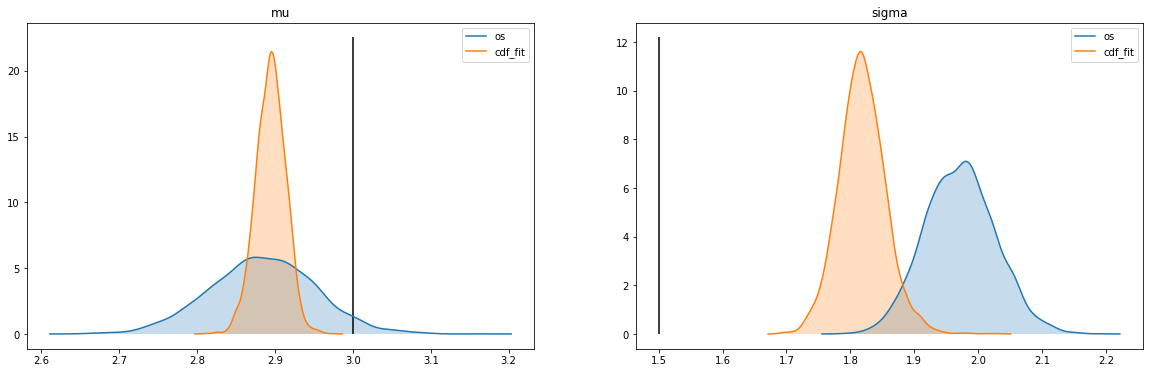

In [15]:
show_models = ["os", "cdf_fit"]
show_params = ["mu", "sigma"]

fig = plot(show_params, show_models, sample_dict);
_ = [ax.vlines(x0, *ax.get_ylim()) for (x0, ax) in zip((loc, scale), fig.axes)]

## $X_{observed}$ vs $X_{pred}$

In [16]:
def get_quantiles(F_inv:"inverse cdf", theta, q):
    return list(map(lambda q_: F_inv(theta, q_), q))


def plot_X_Xpred(X: "array M", X_pred:"array #samples x M", ax, model_name=None):
    low, mid, high = np.percentile(X_pred, [5, 50, 95], axis=0)
    yerr = (mid-low, high-mid)
    ax.errorbar(X, mid, yerr=yerr, marker="x", ls="", label=model_name)

In [17]:
N = 200
q_min, q_max, M = 0.05, 0.95, 20

loc, scale = 3.0, 1.5
f = norm(loc=loc, scale=scale)

q, X = get_data(N, M, q_min, q_max, f)

data_dict = {"N":N, "M":M, "q":q, "X":X}

sample_dict = OrderedDict()
for model_name, model in model_dict.items():
    sample_dict[model_name] = model.sampling(data_dict)

In [18]:
%%time
F_inv = lambda theta, q: norm(loc=theta[0], scale=theta[1]).ppf(q)

X_preds = OrderedDict()
param_names = ["mu", "sigma"]
for model_name, stan_samples in sample_dict.items():
    thetas = np.array([stan_samples.extract(p)[p] for p in param_names])
    X_preds[model_name] = np.array([get_quantiles(F_inv, theta, q) 
                                    for theta in thetas.T])

CPU times: user 1min 45s, sys: 0 ns, total: 1min 45s
Wall time: 1min 45s


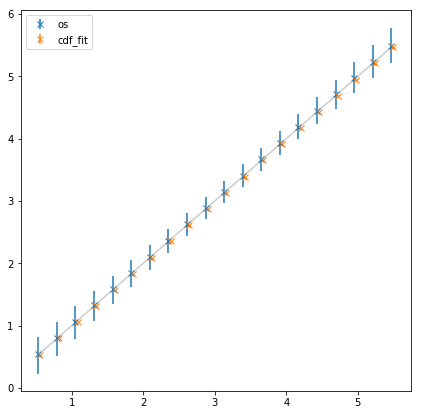

In [19]:
fig, ax = plt.subplots(figsize=(7,7))

for i, (model_name, X_pred) in enumerate(X_preds.items()):
    plot_X_Xpred(X+i*0.03, X_pred, ax, model_name=model_name)
ax.plot([X.min(), X.max()], [X.min(), X.max()], c="black", alpha=0.2)
ax.legend()
plt.show()

In [20]:
%%time
N = 200
q_min, q_max, M = 0.05, 0.95, 20

df, loc, scale = 1, 3.0, 1.5
f = t(df=df, loc=loc, scale=scale)

q, X = get_data(N, M, q_min, q_max, f, equidistant_q=False)


data_dict = {"N":N, "M":M, "q":q, "X":X}

sample_dict = OrderedDict()
for model_name, model in model_dict.items():
    sample_dict[model_name] = model.sampling(data_dict)


F_inv = lambda theta, q: norm(loc=theta[0], scale=theta[1]).ppf(q)

X_preds = OrderedDict()
param_names = ["mu", "sigma"]
for model_name, stan_samples in sample_dict.items():
    thetas = np.array([stan_samples.extract(p)[p] for p in param_names])
    X_preds[model_name] = np.array([get_quantiles(F_inv, theta, q) 
                                    for theta in thetas.T])

CPU times: user 1min 45s, sys: 120 ms, total: 1min 45s
Wall time: 1min 45s


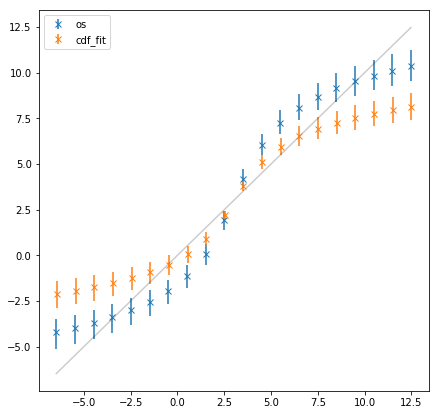

In [21]:
fig, ax = plt.subplots(figsize=(7,7))

for i, (model_name, X_pred) in enumerate(X_preds.items()):
    plot_X_Xpred(X+i*0.03, X_pred, ax, model_name=model_name)
ax.plot([X.min(), X.max()], [X.min(), X.max()], c="black", alpha=0.2)
ax.legend()
plt.show()

In [22]:
for model_name, X_pred in X_preds.items():
    print(model_name, ((X_pred.mean(axis=0)-X)**2).mean())

os 1.6727705205537375
cdf_fit 4.479855602989663
